### 1. Compute Camera Calibration

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
# Will be appended each time we find corners
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

for f in os.listdir('./camera_cal'):
    img = mpimg.imread("./camera_cal/{}".format(f))
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)

### 2. Apply undistort

In [2]:
# Calibrate camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

### 3. Use color transforms, gradients, etc., to create a thresholded binary image.

In [3]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(50,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag > mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir > thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

In [4]:
def get_binary(timg, ksize=15):
    gradx = abs_sobel_thresh(timg, orient='x', sobel_kernel=ksize, thresh=(50, 255))
    grady = abs_sobel_thresh(timg, orient='y', sobel_kernel=ksize, thresh=(50, 255))
    mag_binary = mag_thresh(timg, sobel_kernel=ksize, mag_thresh=(50, 255))
    dir_binary = dir_threshold(timg, sobel_kernel=ksize, thresh=(1, np.pi/2))
    hls_binary = hls_select(timg, thresh=(100, 255))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1))] = 1
    combined[((mag_binary == 1) & (dir_binary == 1))] = 1
    combined[(hls_binary == 1)] = 1

    return combined

### 4. Apply perspective transform

In [5]:
def birds_eye(image, src, offset=50):
    img_size = (image.shape[1], image.shape[0])
    dst = np.float32([[offset, offset], 
                      [img_size[0]-offset, offset], 
                      [img_size[0]-offset, img_size[1]-offset], 
                      [offset, img_size[1]-offset]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)

    return warped

In [6]:
def inverse_birds_eye(image, src, offset=50):
    img_size = (image.shape[1], image.shape[0])
    dst = np.float32([[offset, offset], 
                      [img_size[0]-offset, offset], 
                      [img_size[0]-offset, img_size[1]-offset], 
                      [offset, img_size[1]-offset]])
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(image, Minv, img_size, flags=cv2.INTER_LINEAR)
    return warped

In [7]:
# Identify points
timg = mpimg.imread('./test_images/straight_lines1.jpg')
timg = undistort(timg)

draw_copy = timg.copy()
draw_copy2 = timg.copy()

# pts_for_curvature = np.array([[620,430],
#                 [656,430],
#                 [1086,700],
#                 [231,700],
#                ], np.int32)
# cv2.polylines(draw_copy, [pts_for_curvature], True, (255,0,0), thickness=3)

# original points of the line
pts = np.array([[593,450],
                [692,450],
                [1086,700],
                [231,700],
               ], np.int32)
pts = pts.reshape((-1,1,2))
cv2.polylines(draw_copy, [pts], True, (0, 255,0), thickness=3)

# Shift the source points parallel outwards so we can capture a bigger frame
upper_line_width = 692-593
bottom_line_width = 1086-231
ppts = np.array([[593-upper_line_width*0.2,450],
                [692+upper_line_width*0.2,450],
                [1086+bottom_line_width*0.2,700],
                [231-bottom_line_width*0.2,700],
               ], np.int32)
ppts = ppts.reshape((-1,1,2))
cv2.polylines(draw_copy2, [ppts], True, (0, 255,255), thickness=3)

# Define source as the expanded field
src = np.float32(ppts)

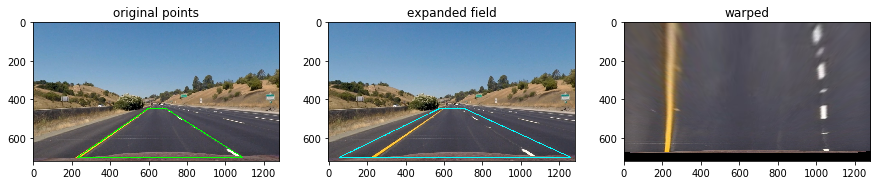

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].imshow(draw_copy)
ax[0].set_title("original points")

ax[1].imshow(draw_copy2)
ax[1].set_title('expanded field')

ax[2].imshow(birds_eye(timg, src))
ax[2].set_title('warped')

plt.savefig('writeup_perspective_trf.jpg')

### 5. Detect lane pixels and fit to find the lane boundary

In [9]:
def get_indexes_around_poly(nonzeroy, nonzerox, prev_poly, margin):
    """
    Helper function to subset activated pixels around a polynomial line
    """
    b2, b1, c = prev_poly
    greater_than = (nonzerox > (b2 * (nonzeroy**2) + b1 * nonzeroy + c - margin))
    less_than = (nonzerox < (b2 * (nonzeroy**2) + b1 * nonzeroy + c + margin))
    return greater_than & less_than


def get_x_and_y(img_shape, left_poly, right_poly):
    """
    Helper function to get X and Y values based on the fitted polynomial
    """
    ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])
    fitted_left_x = left_poly[0] * ploty**2 + left_poly[1] * ploty + left_poly[2]
    fitted_right_x = right_poly[0] * ploty**2 + right_poly[1] * ploty + right_poly[2]

    return fitted_left_x, fitted_right_x, ploty

In [10]:
def sliding_window_pixels(binary_warped, draw_intermediate):
    """
    Finds pixels by determining middle points and then using sliding windows
    """
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] // 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    nwindows = 9  # Choose the number of sliding windows
    margin = 100  # Set the width of the windows +/- margin
    minpix = 50  # Set minimum number of pixels found to re-center window

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0] // nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Create empty image
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    out_img = np.uint8(out_img)

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
    
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,
                      (win_xleft_low,win_y_low),
                      (win_xleft_high,win_y_high),
                      (0,255,0), 2) 
        cv2.rectangle(out_img,
                      (win_xright_low,win_y_low),
                      (win_xright_high,win_y_high),
                      (255,0,0), 2) 

        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, re-center next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    if draw_intermediate:
        fig, ax = plt.subplots()
        plt.imshow(out_img)
        plt.title("sliding windows!")

    return leftx, lefty, rightx, righty


def find_lane_pixels(binary_warped, prev_left_poly, prev_right_poly,
                     prev_left_points, prev_right_points,
                     margin, add_points_margin=None, draw_intermediate=False):
    """
    Function to find lane pixels based on the binary image, and any previous fitted lines & points
    
    Args:
        prev_left_points (tuple) : should be type (prev_img_leftx, prev_img_lefty)
        margin (int) : margin around polynomial to keep points
        add_poitns_margin (int) : margin around polynomial to add points
    """
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    out_img = np.uint8(out_img)

    # First grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Get the correct pixels based on (a) prev poly or (b) sliding window
    if (prev_left_poly != None) & (prev_right_poly != None):
        left_lane_inds = get_indexes_around_poly(nonzeroy, nonzerox, prev_left_poly, margin)
        right_lane_inds = get_indexes_around_poly(nonzeroy, nonzerox, prev_right_poly, margin)
        img_leftx = nonzerox[left_lane_inds]
        img_lefty = nonzeroy[left_lane_inds]
        img_rightx = nonzerox[right_lane_inds]
        img_righty = nonzeroy[right_lane_inds]
    else:
        img_leftx, img_lefty, img_rightx, img_righty = sliding_window_pixels(binary_warped, draw_intermediate)

    # Add extra points within a narrow margin
    # This helps if the image have few to no activated pixels
    if add_points_margin:
        if (prev_left_points != None) & (prev_right_points != None):
            prev_left_inds = get_indexes_around_poly(prev_left_points[1], prev_left_points[0], prev_left_poly, add_points_margin)
            prev_right_inds = get_indexes_around_poly(prev_right_points[1], prev_right_points[0], prev_right_poly, add_points_margin)
            img_leftx = np.append(img_leftx, prev_left_points[0][prev_left_inds])
            img_lefty = np.append(img_lefty, prev_left_points[1][prev_left_inds])
            img_rightx = np.append(img_rightx, prev_right_points[0][prev_right_inds])
            img_righty = np.append(img_righty, prev_right_points[1][prev_right_inds])

    if draw_intermediate:
        fig, ax = plt.subplots()
        out_img[img_lefty, img_leftx] = [255, 0, 0]
        out_img[img_righty, img_rightx] = [0, 0, 255]
        plt.imshow(out_img)
        plt.title("lane pixels found")

    return img_leftx, img_lefty, img_rightx, img_righty

### 6. Find lane curve and skew

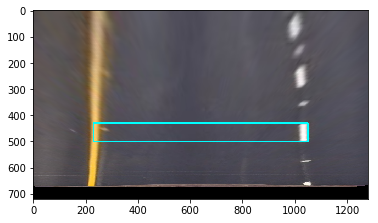

In [11]:
# Define xm and ym_per_pix
warped = birds_eye(timg, src)
x_start = 230
x_end = 1050
y_start= 430
y_end = 500
cv2.polylines(warped, [np.array([[x_start, y_end], [x_end, y_end],  [x_end, y_start], [x_start, y_start]])], 
              True, (0,255,255), thickness=3)
xm_per_pix = 3.7/(x_end-x_start)
ym_per_pix = 3/(y_end-y_start)
plt.imshow(warped)

In [12]:
def curve_radians(poly_coefficients, y_eval):
    """
    Calculate the curve of a polynomial line in METRES
    """
    b2, b1, c = poly_coefficients
    curve_rad = ((1 + (2 * b2 * y_eval * ym_per_pix + b1)**2)**1.5) / np.absolute(2 * b2)
    return curve_rad


def get_skew(left_poly, right_poly, y_eval, img_width):
    """
    Calculate the driver's skew from the midpoint of the lane in METRES
    """
    left_x = left_poly[0]*(y_eval**2) + left_poly[1]*y_eval + left_poly[2]
    right_x = right_poly[0]*(y_eval**2) + right_poly[1]*y_eval + right_poly[2]
    lane_midpoint = (left_x + right_x)/2
    img_midpoint = img_width/2
    if lane_midpoint >= img_midpoint:
        return "left", (lane_midpoint-img_midpoint)*xm_per_pix
    else:
        return "right", (img_midpoint-lane_midpoint)*xm_per_pix

### 6b. Combine into one function

In [13]:
def fit_lane_curve(binary_warped, 
                   prev_left_poly=None, prev_right_poly=None,
                   prev_left_points=None, prev_right_points=None,
                   margin=30, weight=0.2,
                   add_points_margin=None, draw_intermediate=False):

    img_leftx, img_lefty, img_rightx, img_righty = find_lane_pixels(binary_warped,
                                                                    prev_left_poly, prev_right_poly,
                                                                    prev_left_points, prev_right_points,
                                                                    margin, 
                                                                    add_points_margin,
                                                                    draw_intermediate)

    # Fit the new line
    _left_poly = np.polyfit(img_lefty, img_leftx, 2)
    _right_poly = np.polyfit(img_righty, img_rightx, 2)
    _fitted_left_x, _fitted_right_x, ploty = get_x_and_y(binary_warped.shape, _left_poly, _right_poly)

    # Get the old drawn line from prev
    if (prev_left_poly != None) & (prev_right_poly != None):
        prev_fitted_left_x, prev_fitted_right_x, _ = get_x_and_y(binary_warped.shape, prev_left_poly, prev_right_poly)
        fitted_left_x = weight*_fitted_left_x + (1-weight)*prev_fitted_left_x
        fitted_right_x = weight*_fitted_right_x + (1-weight)*prev_fitted_right_x
    else:
        fitted_left_x = _fitted_left_x
        fitted_right_x = _fitted_right_x

    # Get the weighted average polyfit
    left_poly = np.polyfit(ploty, fitted_left_x, 2)
    right_poly = np.polyfit(ploty, fitted_right_x, 2)

    ### OPTION: JUST FIT
    #left_poly = np.polyfit(img_lefty, img_leftx, 2)
    #right_poly = np.polyfit(img_righty, img_rightx, 2)
    #fitted_left_x, fitted_right_x, ploty = get_x_and_y(binary_warped.shape, left_poly, right_poly)

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = curve_radians(left_poly, y_eval)
    right_curverad = curve_radians(right_poly, y_eval)
    
    # Get the skew off center
    skew_dir, skew_value = get_skew(left_poly, right_poly, y_eval, binary_warped.shape[1])

    # Plot for debugging
    if draw_intermediate:
        out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
        out_img = np.uint8(out_img)
        draw_curve(out_img, fitted_left_x, ploty, (255, 255, 0), thickness=3)
        draw_curve(out_img, fitted_right_x, ploty, (255, 255, 0), thickness=3)
        fig, ax = plt.subplots()
        plt.imshow(out_img)
        plt.title("fitted curves")

    return left_poly, right_poly, \
        (img_leftx, img_lefty), (img_rightx, img_righty), \
        fitted_left_x, fitted_right_x, ploty, \
        left_curverad, right_curverad, \
        skew_dir, skew_value

### 7. Warp the detected lane boundaries back onto the original image

In [14]:
def draw_curve(img, left, ploty, color, thickness=50):
    pts = np.array([[x, y] for x, y in zip(left, ploty)], np.int32)
    pts = pts.reshape((-1,1,2))
    cv2.polylines(img, [pts], False, color, thickness)

In [15]:
def fill_space(img, left_fitx, right_fitx, ploty):
    left_pts = [[x, y] for x, y in zip(left_fitx, ploty)]
    right_pts = [[x,y] for x, y in zip(right_fitx, ploty)]
    all_pts = left_pts + right_pts[::-1]
    pts = np.array(all_pts, np.int32)
    cv2.fillPoly(img, [pts], (0, 0, 255))

In [16]:
def make_overlay(img, left_fitx, right_fitx, ploty):
    to_impose = np.zeros_like(timg)
    fill_space(to_impose, left_fitx, right_fitx, ploty)
    draw_curve(to_impose, left_fitx, ploty, (255, 0, 0))
    draw_curve(to_impose, right_fitx, ploty, (0, 255, 0))
    return to_impose

### 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

In [17]:
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [18]:
def annotate(img, cleft, cright, skew_dir, skew_value): 
    font = cv2.FONT_HERSHEY_SIMPLEX
    pos = (50, 50) 
    fontScale = 1
    color = (255, 255, 255) 
    thickness = 2
    text = []
    text.append('Curvature (left) = {}km'.format(round(cleft/1000, 2)))
    text.append('Curvature (right) = {}km'.format(round(cright/1000, 2)))
    text.append('Vehicle position = {}m to the {}'.format(round(skew_value, 2), skew_dir))
    
    for t in text:
        cv2.putText(img, t, pos, font,  fontScale, color, thickness, cv2.LINE_AA)
        pos = (pos[0], pos[1] + 50)

## Run your video

In [19]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [20]:
prev_left_poly, prev_right_poly = None, None
prev_left_points, prev_right_points = None, None

def process_image(image):
    
    # Set global versions
    global prev_left_poly
    global prev_right_poly
    global prev_left_points
    global prev_right_points
    global count
    
    # Params
    search_margin = 30
    new_weight = 0.6
    add_points_margin = None

    # Fix distort
    image = undistort(image)
    
    # Detect lanes
    cleaned = get_binary(image)
    cleaned = birds_eye(cleaned, src)
    out = fit_lane_curve(cleaned, 
                         prev_left_poly, prev_right_poly, 
                         prev_left_points, prev_right_points,
                         search_margin, new_weight,
                         add_points_margin)
    left_poly, right_poly, left_points, right_points,\
        fitted_left_x, fitted_right_x, ploty, \
        left_curverad, right_curverad, \
        skew_dir, skew_value = out
    
    # Prepare the final image
    overlay = make_overlay(image, fitted_left_x, fitted_right_x, ploty)
    overlay = inverse_birds_eye(overlay, src)
    final = weighted_img(overlay, image)
    annotate(final, left_curverad, right_curverad, skew_dir, skew_value)
    
    # Reset the global variables
    prev_left_poly = left_poly
    prev_right_poly = right_poly
    prev_left_points = left_points
    prev_right_points = right_points
    
    return final

### Sample

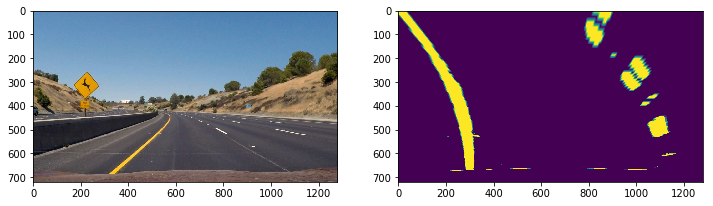

In [27]:
test = mpimg.imread('./test_images/test2.jpg')
bin_warped = undistort(test)
bin_warped = get_binary(bin_warped)
bin_warped = birds_eye(bin_warped, src)
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
ax[0].imshow(test)
ax[1].imshow(bin_warped)

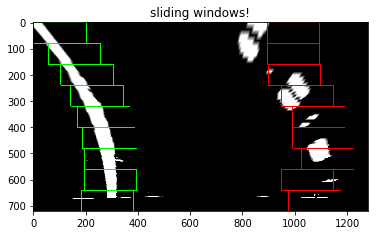

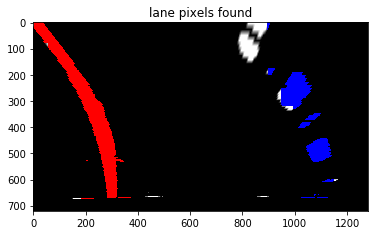

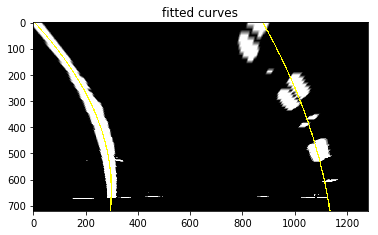

In [28]:
temp = fit_lane_curve(bin_warped, draw_intermediate=True)
# unpack
left_poly, right_poly, left_points, right_points, fitted_left_x, fitted_right_x, ploty, \
    left_curverad, right_curverad, skew_dir, skew_value = temp

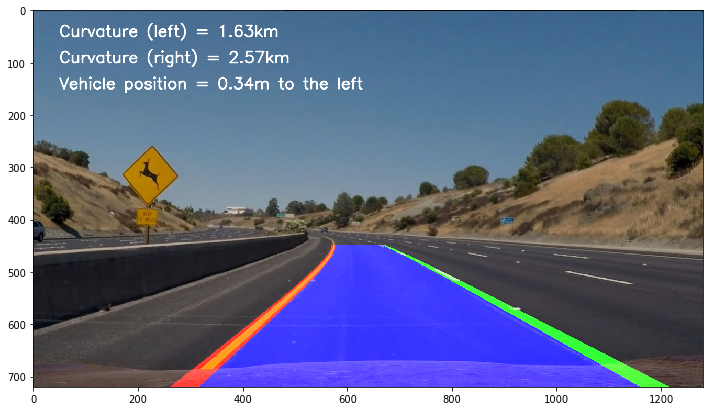

In [33]:
overlay = make_overlay(img, fitted_left_x, fitted_right_x, ploty)
overlay = inverse_birds_eye(overlay, src)
final = weighted_img(overlay, test)
annotate(final, left_curverad, right_curverad, skew_dir, skew_value)
fig, ax = plt.subplots(figsize=(12,7))
plt.imshow(final)
plt.savefig('writeup_final.jpg')

### Full original

In [22]:
output_file = 'project_output.mp4'
clip1 = VideoFileClip("project_video.mp4") #.subclip(0, 2)
input_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time input_clip.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [09:19<00:00,  2.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 6min 9s, sys: 26.7 s, total: 6min 36s
Wall time: 9min 22s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('project_output.mp4'))